## Préparation des données

### Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import seaborn as sns
from sklearn import cluster, metrics
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from fonctions import *

### Data

In [3]:
df_etude = pd.read_csv('df_etude.csv')

In [4]:
#df_etude.head()

In [5]:
df_etude.set_index('Zone', inplace=True)
print(df_etude.shape)
#df_etude.head()

(165, 7)


In [6]:
X = df_etude.select_dtypes('number') #Récupération des valeurs
print('X', X.shape)

X (165, 7)


In [7]:
y = df_etude.index #Sauvegarde des noms des zones
print('y', y.shape)

y (165,)


#### Normalisation

In [8]:
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns).round(2)
print('X_scaled', X_scaled.shape) 

X_scaled (165, 7)


## Analyse des données

#### Analyse en composantes principales (PCA).

In [9]:
num_components = 7
pca = PCA(n_components=num_components)
pca.fit(X_scaled)

PCA(n_components=7)

In [10]:
# Donnée expliqué en fonction du nombre de composantes principales retenue
pca = decomposition.PCA(n_components = num_components)
pca.fit(X_scaled)
tableau_variance = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(num_components)], 
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
tableau_variance

,Dimension,% cum. var. expliquée
0,Dim1,49.0
1,Dim2,70.0
2,Dim3,81.0
3,Dim4,89.0
4,Dim5,96.0
5,Dim6,99.0
6,Dim7,100.0


##### Analyse des resultats

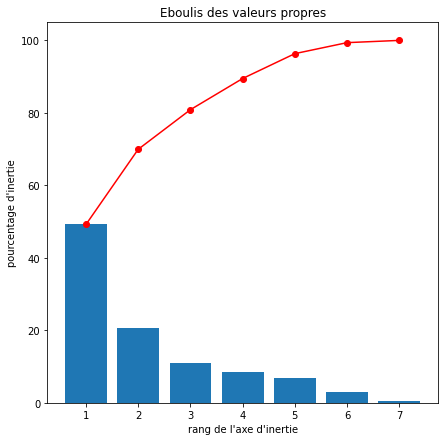

<Figure size 432x288 with 0 Axes>

In [11]:
fig = plt.figure(figsize=(7, 7))
display_scree_plot(pca)
plt.savefig('eboulis.png')

##### Cercle de corrélation

<Figure size 720x720 with 0 Axes>

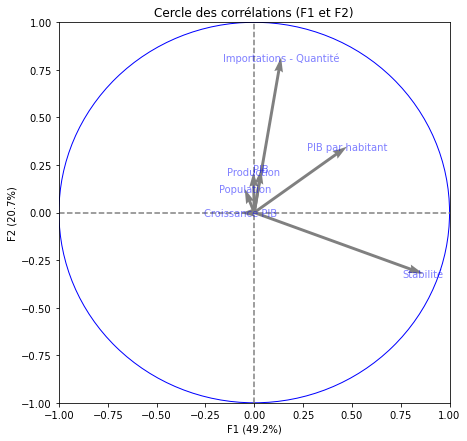

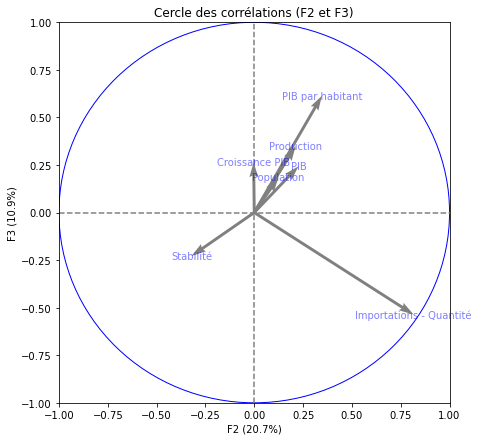

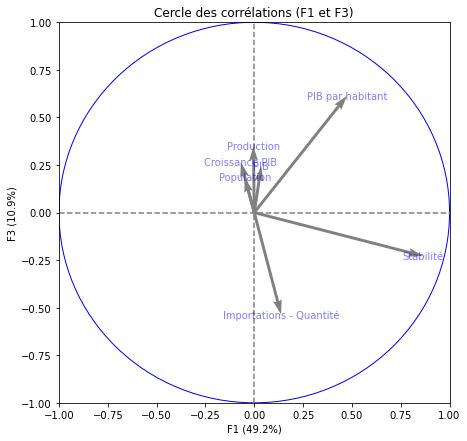

<Figure size 432x288 with 0 Axes>

In [12]:
pcs = pca.components_ 
fig = plt.figure(figsize=(10, 10))
display_circles(pcs, num_components, pca, [(0,1), (1,2), (0,2)], labels = np.array(X.columns))

plt.savefig('individu_point.png')

In [13]:
#Data Frame avec les 3 variables a retenir
df_etude = df_etude[['PIB par habitant', 'Stabilité', 'Importations - Quantité']]

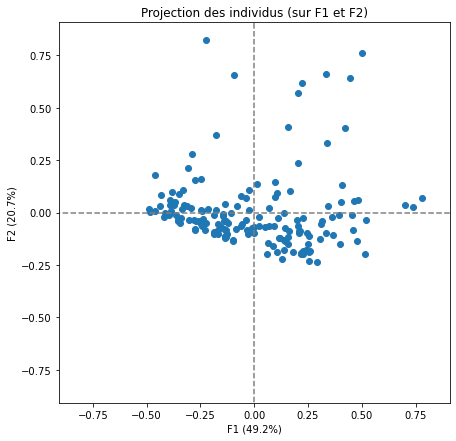

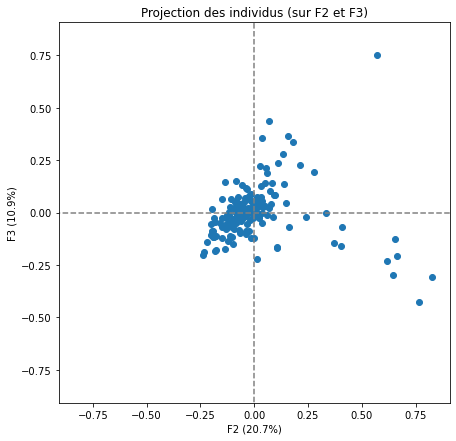

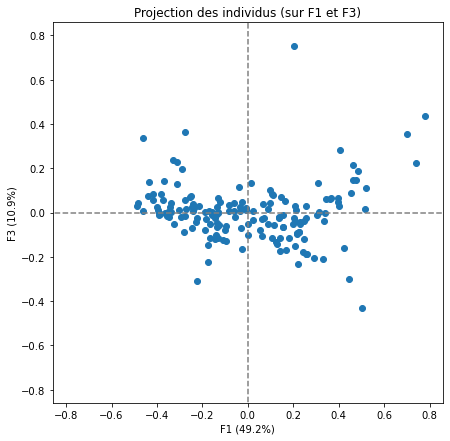

In [14]:
# Projection des individus sur un espace vectoriel 
X_projected = pca.transform(X_scaled) 

display_factorial_planes(X_projected, num_components, pca, [(0,1), (1,2), (0,2)])
plt.show()

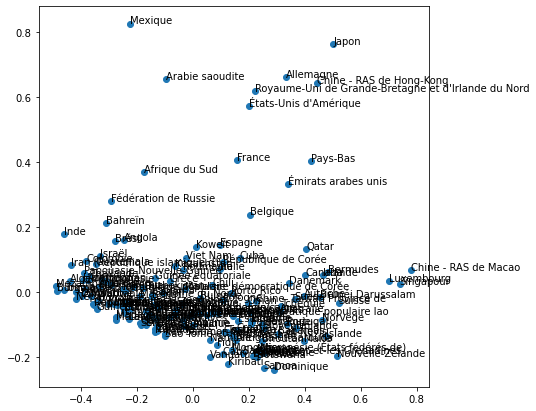

In [15]:
# Projection des individus avec leur nom sur un espace vectoriel 
fig = plt.figure(figsize=(7, 7))
plt.scatter(X_projected[:,0], X_projected[:, 1])
for i, (x, y) in enumerate(zip(X_projected[:, 0],
                              X_projected[:,1])):
    plt.text(x, y, X.index[i] )
    plt.savefig('individu.png')

In [16]:
# Création d'un model PCA à 2 dimensions pour afficher nos données sur 2 dimensions
pca = PCA(n_components=3)
pca.fit(X_scaled)
# Transfere les données sur le nouveau PCA 2D
X_reduced = pca.transform(X_scaled)

### Partitionnement des données avec un algorithme de clustering hiérarchique et une Classification ascendante hiérarchique. (CAH)

#### Clustering hiérarchique

In [47]:
X = df_etude.select_dtypes('number') #Récupération des valeurs
print('X', X.shape)

X (165, 3)


In [48]:
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns).round(2)
print('X_scaled', X_scaled.shape) 

X_scaled (165, 3)


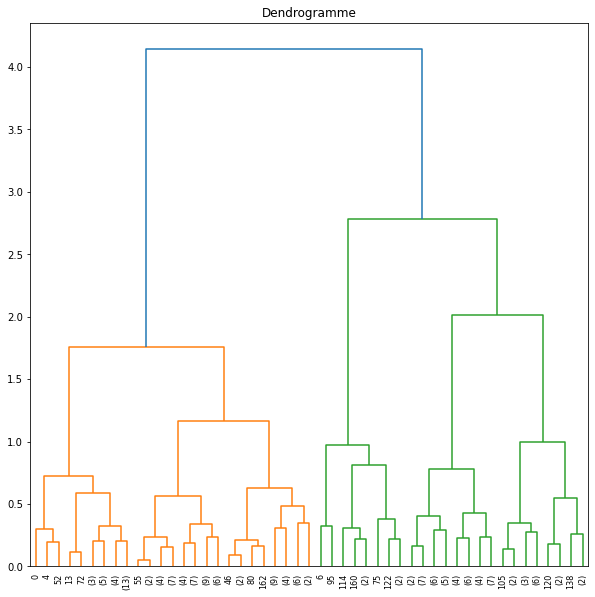

In [49]:
Z = linkage(X_scaled, 'ward')
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
dn = dendrogram(Z ,truncate_mode="level", p=5);
plt.title('Dendrogramme');
plt.savefig('cah.png')

In [50]:
# Création d'un model hiérarchique
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True) 

In [51]:
# Sur une base de 3 clusters sois 81% des données expliquées
# Ajuste les données au modèle et détermine à quels clusters appartient chaque individu  :
hiercluster.set_params(n_clusters=3)
clusters_cah = hiercluster.fit_predict(X_scaled) 
np.bincount(clusters_cah) # Nombre d'individu par cluster

array([59, 96, 10], dtype=int64)

In [52]:
# Ajoute le numéro du cluster au donnée
X_scaled_clustered_cah = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered_cah['cluster'] = clusters_cah

#X_scaled_clustered_cah.head(200)

In [53]:
# Determine la taille des clusters
X_scaled_clustered_cah["cluster"].value_counts()

1    96
0    59
2    10
Name: cluster, dtype: int64

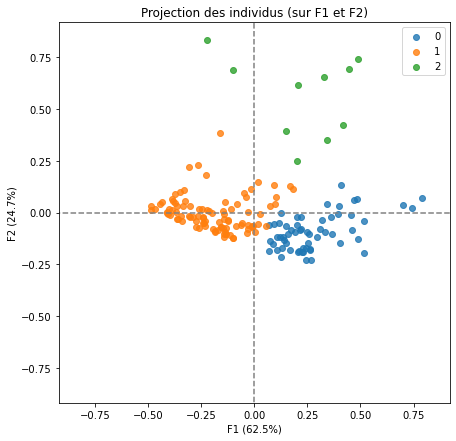

In [54]:
#Affiche les individus sur un plan avec leurs clusters
display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = clusters_cah, alpha = 0.8)

### K-Means

In [55]:
X = df_etude

In [56]:
#Normalisation des données
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled

##### Methode du coude  Eboulis

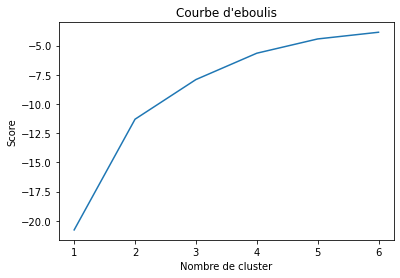

In [57]:
# Lance 10 fois le teste et garde la meilleur solution
num_clusters = 7
kmeans_tests = [KMeans(n_clusters=i, init='k-means++', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans_tests))]

# Affiche la courbe d'eboulis
plt.plot(range(1, num_clusters),score)
plt.xlabel('Nombre de cluster')
plt.ylabel('Score')
plt.title('Courbe d\'eboulis')
plt.show()

In [58]:
# Création du model de clustering k-means pour 3 clusters
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
# Ajuste les données au model
kmeans.fit(X_scaled)
# Determine le cluster de chaque individu
clusters_k =  kmeans.predict(X_scaled)

In [59]:
# Ajoute le numéros du cluster aux donénes
X_scaled_clustered_k = pd.DataFrame(X_scaled, columns=X.columns, index=X.index).round(2)
X_scaled_clustered_k['cluster'] = clusters_k

X_scaled_clustered_k.head()

,PIB par habitant,Stabilité,Importations - Quantité,cluster
Zone,,,,
Afrique du Sud,0.09,0.26,0.48,1
Albanie,0.09,0.52,0.04,0
Algérie,0.08,0.02,0.00,0
Allemagne,0.41,0.60,0.79,1
Angola,0.05,0.24,0.26,0


In [60]:
# Determine la taille des clusters
X_scaled_clustered_k["cluster"].value_counts()

0    86
2    69
1    10
Name: cluster, dtype: int64

In [61]:
# Création d'un model PCA à 2 dimensions pour afficher nos données sur 2 dimensions
pca = PCA(n_components=2)
pca.fit(X_scaled)
# Transfere les données sur le nouveau PCA 2D
X_reduced = pca.transform(X_scaled)

In [62]:
# Convertion des résultats en dataframe
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters_k
X_reduceddf.head()

,PC1,PC2,cluster
Zone,,,
Afrique du Sud,-0.159433,0.383170,1
Albanie,0.002199,-0.092633,0
Algérie,-0.443245,0.039495,0
Allemagne,0.329075,0.653439,1
Angola,-0.227020,0.179384,0


##### Centroide

In [63]:
centres_reduced = pca.transform(kmeans.cluster_centers_)
X_trans = pca.transform(X_scaled)

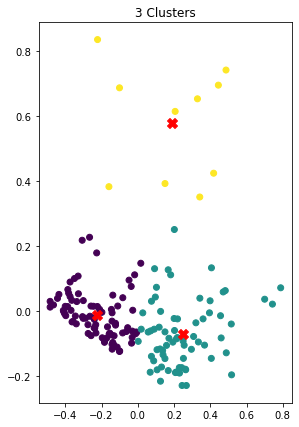

In [64]:
fig = plt.figure(figsize=(10,7))
cls3 = cluster.KMeans(n_clusters=3)
cls3.fit(X_scaled)
ax = fig.add_subplot(121)
plt.title('3 Clusters')
ax.scatter(X_trans[:,0], X_trans[:, 1], c=cls3.labels_)
plt.scatter(centres_reduced[:,0],centres_reduced[:,1],s = 100, c = 'r',marker = 'X')

### Clustermap Cah & K-means

In [65]:
#Heatmap avec CAH
heatmap_cah = X_scaled_clustered_cah.groupby(['cluster']).mean()
print(heatmap_cah.shape)
#heatmap.head()

(3, 3)


In [66]:
#Heatmap avec Kmeans
heatmap_k = X_scaled_clustered_k.groupby(['cluster']).mean()
print(heatmap_k.shape)
#heatmap.head()

(3, 3)


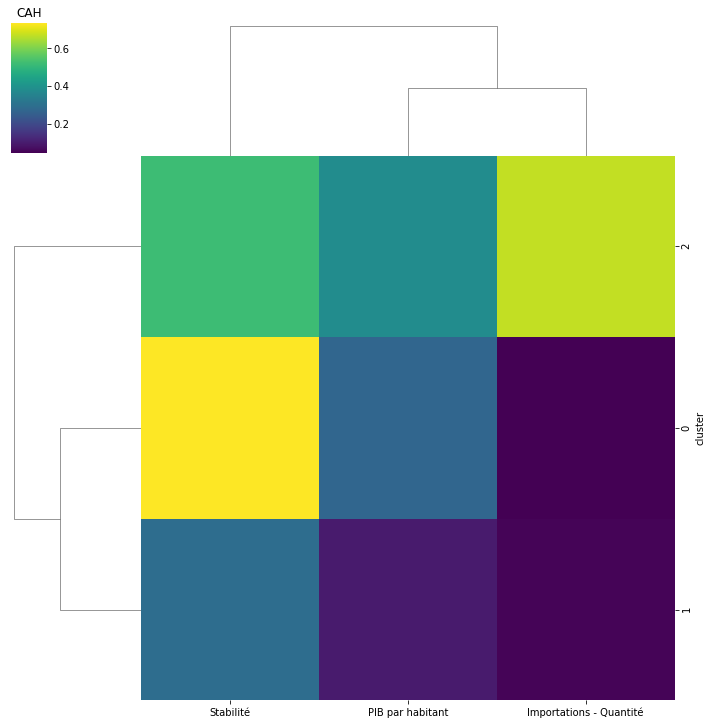

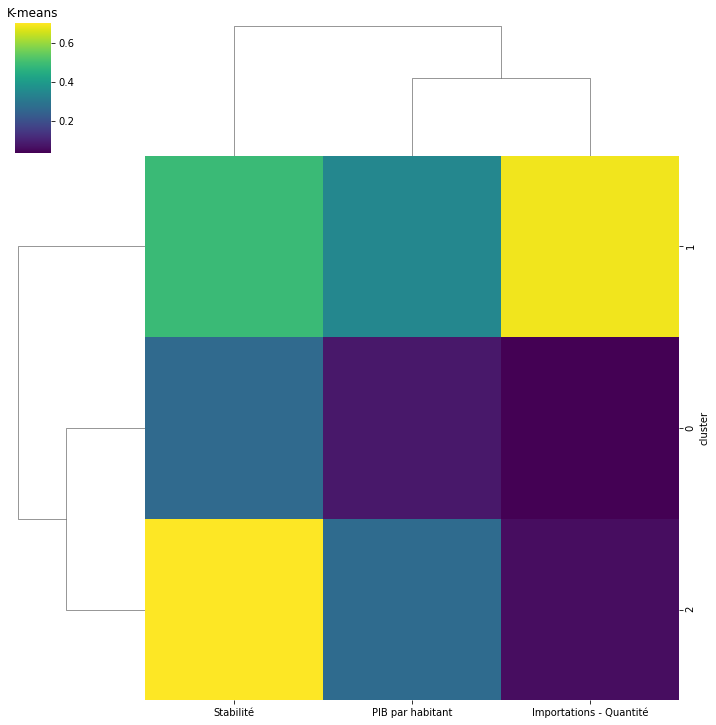

In [67]:
sns.clustermap(heatmap_cah, cmap = 'viridis', method = 'ward')
plt.title('CAH')
plt.savefig('heatmap_cah.png')

sns.clustermap(heatmap_k, cmap = 'viridis', method = 'ward')
plt.title('K-means')
plt.savefig('heatmap_k.png')

In [77]:
cah = 2
k = 1

In [78]:
#Cluster avec CAH
cluster_cah = X_scaled_clustered_cah[(X_scaled_clustered_cah['cluster'] == cah)]
print(cluster_cah.shape)
cluster_cah.head(10)

(10, 4)


,PIB par habitant,Stabilité,Importations - Quantité,cluster
Zone,,,,
Allemagne,0.41,0.60,0.79,2
Arabie saoudite,0.37,0.15,0.68,2
Belgique,0.39,0.54,0.32,2
Chine - RAS de Hong-Kong,0.47,0.69,0.85,2
France,0.35,0.48,0.47,2
Japon,0.32,0.80,1.00,2
Mexique,0.15,0.09,0.91,2
Pays-Bas,0.43,0.73,0.57,2
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,0.36,0.50,0.73,2


In [79]:
#Cluster avec Kmeans
cluster_k = X_scaled_clustered_k[(X_scaled_clustered_k['cluster'] == k)]
print(cluster_k.shape)
cluster_k.head(10)

(10, 4)


,PIB par habitant,Stabilité,Importations - Quantité,cluster
Zone,,,,
Afrique du Sud,0.09,0.26,0.48,1
Allemagne,0.41,0.60,0.79,1
Arabie saoudite,0.37,0.15,0.68,1
Chine - RAS de Hong-Kong,0.47,0.69,0.85,1
France,0.35,0.48,0.47,1
Japon,0.32,0.80,1.00,1
Mexique,0.15,0.09,0.91,1
Pays-Bas,0.43,0.73,0.57,1
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,0.36,0.50,0.73,1


In [80]:
# Supression de la colonne cluster
cluster_cah = cluster_cah.drop("cluster", axis='columns')
cluster_k = cluster_k.drop("cluster", axis='columns')

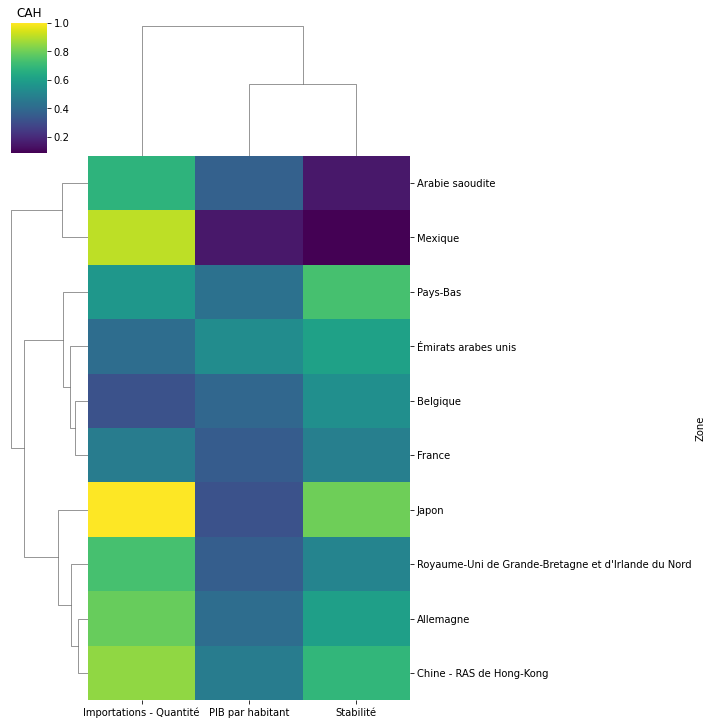

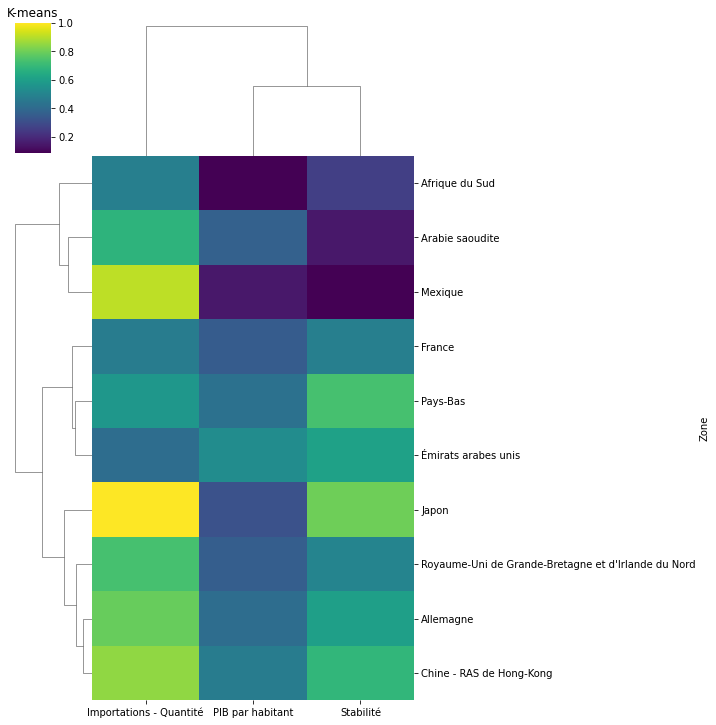

In [81]:
#Heatmap des clusters retenue selon CAH ou Kmeans
sns.clustermap(cluster_cah, cmap = 'viridis', method = 'ward')
plt.title('CAH')
plt.savefig('heatmap_cah_pays_valide.png')

sns.clustermap(cluster_k, cmap = 'viridis', method = 'ward')
plt.title('K-means')
plt.savefig('heatmap_k_pays_valide.png')

### Comparaison entre CAH et Kmeans

##### Utilisation de la methode d'ARI

In [82]:
from sklearn.metrics.cluster import adjusted_rand_score

In [83]:
adjusted_rand_score(clusters_cah, clusters_k)

0.7787794806761281

In [84]:
X_scaled_clustered_k.loc[['Belgique', 'Afrique du Sud']]

,PIB par habitant,Stabilité,Importations - Quantité,cluster
Zone,,,,
Belgique,0.39,0.54,0.32,2
Afrique du Sud,0.09,0.26,0.48,1


In [85]:
X_scaled_clustered_cah.loc[['Belgique', 'Afrique du Sud']]

,PIB par habitant,Stabilité,Importations - Quantité,cluster
Zone,,,,
Belgique,0.39,0.54,0.32,2
Afrique du Sud,0.09,0.26,0.48,1
